In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

## Ensemble Learning and Random Forest

General Idea: aggregating the predictions of a group of predictors (such as classifiers or regressors), will often result in better predictions than with the best individual predictor. A group of predictors is called an *ensemble*; this, this technique is called *Ensemble Learning*, and an Ensemble Learning Algorithm is called an *Ensemble Method*.

For example, aggregating the predictions of a group of **Decision Trees** is called a *Random Forest*.


Popular methods include: bagging, boosting, stacking, etc.

## Voting Classifiers

Suppose you have trained a few classifiers (Logistic Regression, SVM, Random Forest, kNN, etc.). A simple way to create a better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier. This type of classifier often achieves a higher accuracy than the best classifier in the ensemble. Even if each classifier is a weak learner (ir does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there ar ea sufficient number of weak learners and they are sufficiently diverse.

<img src="images/chapter7/hardvoting.png">

suppose you build an ensemble containing 1000 classifiers that are individually correct only 51% of the time. If you predict the majority voted clsas, you can hope for up to 75% accuracy. However, this is only true if all classifiers are perfectly independent, making uncorrelated erros, which is not the case since they are trained on the same data. They are likely to make the same types of erros, so there will be many majority votes for the wrong class, reducing the ensemble's accuracy. Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#initialize the models
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


The voting classifier outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities, then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers (This is called *soft voting*). It often achieves higher performance than hard voting because it gives more weight to highly confident votes. You can replace voting="soft" and ensure that all classifiers can estimate probabilites.

SVC by default does not estimate probabilities, so you need to set its probability hyperparameter to True.

## Bagging and Pasting

Another approach is to use the same training algorithm for ever predictor, but to train them on different random subsets of the training set. When sampling is performed with replacement, this is called bagging. When sampling is performed without replacement, it is called pasting.

<img src="images/chapter7/baggingpasting.png">

Bagging and Pasting allow for a particular training instances to be sampled several times across multiple predictors, but only bagging allows for that training instance to be sampled several times for the same predictor. Since in pasting, if you sampled a particular training instance, that same training instance won't be available to be sampled for the next predictor (since we are sampling without replacement).

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors (typically the statistical mode - most frequent prediction, similar to hard voting classifier for classification problems and the average for regression problems). Aggregation reduces both bias and variance.

Bagging and Pasting in Scikit-Learn:

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#trains an ensemble of 500 decision tree classifiers
#each trained on 100 training instances randomly sampled from the training set with replacement -- bagging
#for pasting set bootstrap = False

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples=100, bootstrap=True, n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [8]:
#bagging model score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [9]:
#regular Decision Tree score
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

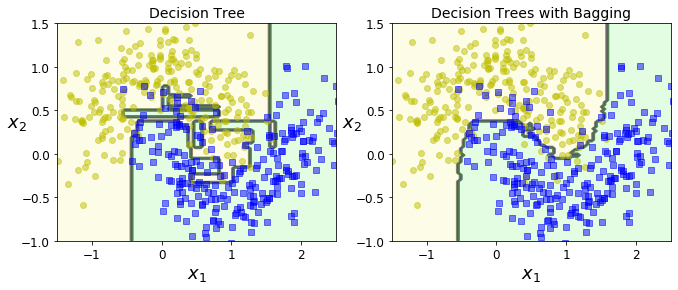

In [11]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.show()

Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting, but this also
means that predictors end up being less correlated so the ensemble’s variance is
reduced. Overall, bagging often results in better models, which explains why it is generally preferred.

## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all.By default a BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation. You can evaluate the ensemble itself by averaging out the oob evluations of each predictor.

In Scikit-Learn, you can set oob_score=True when creating a BagginClassifier to request an qutomatic oob evaluation after training. The followin code demonstrates this:

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [15]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

The oob decision function for each training instance is also available through the oob_decision_function_ variable. In this case, the decision function returns the class probabilities for each training instance. For example, the oob evaluation estimates that the second training instance has a 34.1% probability of belonging to the positive class (and 65.9% of belonging to the positive class).

In [16]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

## Random Patches and Random Subspaces

BaggingClassifier also supports sampling features. This is controlled by two parameters: max_features and bootstrap_features. Thus, each predictor will be trained on a random subset of the input features.

This is useful when you are dealing with high-dimensional inputs such as images. Sampling both training instances and features is called Random Patches method. Keeping all training instances but sampling features (bootstrap_features=True and/or max_features smaller than 1.0) is called *Random Subspaces* method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.


## Random Forests

A Random Forest is an ensemble of Decision Trees, generally trained via the bagging method. The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes).

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,  n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [21]:
#bagging Decision Tree model comparison

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42
)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

In [22]:
#similar predictions
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976

## Extra Trees

When training a Random Forest, at each split, it is possible to make trees even more random by also using random thresholds for each feature, rather than searching for the best possible thresholds. A forest of such nature is called an *Extremely Randomized Trees* ensemble. This results in trading more bias for a lower variance. Since we're no longer looking for the best threshold, this makes it faster to train this type of model.

You can create an Extra-Trees Classifier via Scikit-Learn's ExtraTreesClassifier.

## Feature Importance

For a decision tree, important features tend to appear closer to the root, while unimportant features will often appear closer to the leaves. So we can get a sense of a feature's importance by computing the average depth at which it appears across all trees in the forest. Scikit-Learn computes this automatically for every feature after training. You can access the result using the feature_importances_ variable. See the following code on the iris dataset.

In [24]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


It seems that the most important feature is petal length (44%) and width (42%), while sepal length and width are unimportant.

## Boosting

Boosting refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are several boosting methods available, but some of the most popular methods are AdaBoost and Gradient Boosting.

## AdaBoost

One way for a new predictor to correct its predecessor is to pay more attention to thee training instances that the predecessor underfitted. This results in the new predicotrs focussing more and more on the hard cases. This is the general strategy of AdaBoost.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

<img src="images/chapter7/adaboost.png">


Scikit-Learn uses a multiclass version of AdaBoost called SAMME (Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are two classes SAMME is equivalent to AdaBoost. If the predictors can estimate class probabilties, Scikit-Learn can use a variant of SAMME called SAMME.R, which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 200 Decision Stumps (Decision trees with a single decision node and two leaf nodes).

In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

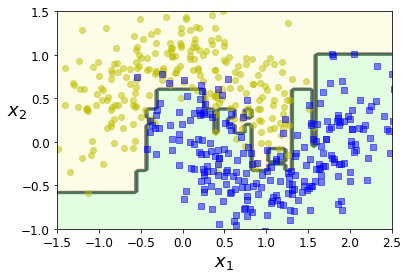

In [26]:
plot_decision_boundary(ada_clf, X, y)

The figure below shows the decision boundaries of five consecutive predictors on the moons dataset. The first classifier gets many instances wrong, so their weights get boosted. The second classifier  does a better job on these instances, and so on. The plot on the right represents the same sequences of predictors except that the learning rate is halved ( the misclassified instance weights are boosted half as much at every iteration). It is similar to gradient descent, except that instead of tweaking a single predictor's parameters to minimize a cost function, we are adding predictors to the ensemble, gradually making it better.

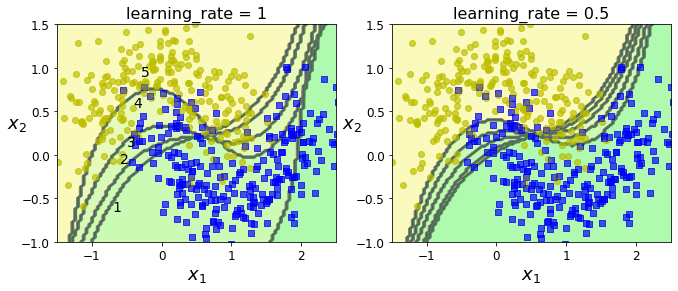

In [28]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

Once all predictors are trained, the ensemble makes predictions similar to bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

## AdaBoost Algorithm

Each instance weight $w^{(i)}$  is initially set to $\frac{1}{m}$. The first predictor is trained and its weighted error rate $r_1$ is computed on the training set:

weighted error rate of the jth predictor:

\begin{equation*}
r_j = \frac{\sum_{\substack{i=1 \\ \hat{y_j}^{(i)}\neq y^{(i)}}}^m w^{(i)}}{\sum_{i=1}^m w^{(i)}}
\end{equation*}

where $\hat{y_j}^{(i)}$ is the jth predictor's prediction for the ith instance.

The predictor's weight $\alpha_j$ is then computed using:

\begin{equation*}
\alpha_j = \eta \log({\frac{1-r_j}{r_j}})
\end{equation*}

where $\eta$ is the learning rate. The more accurate the predictor is, the higher its weight will be. If it is randomly guessing, then its weight will be close to zero, and if it is often wrong, its weight will be negative.

Next, the weights are updated via:

\begin{equation*}
w^{(i)} \leftarrow
\begin{cases}
w^{(i)} & \text{if $\hat{y_j}^{(i)}$ = $y_j^{(i)}$} \\ 
w^{(i)}exp(\alpha_j) & \text{if $\hat{y_j}^{(i)} \neq y_j^{(i)}$}
\end{cases}
\end{equation*}

Then all the instance weights are normalized (divided by $\sum_{i=1}^{m}w^{(i)}$.

A new predictor is trained with the updated weights, and the entire process is repeated. The algorithm stops when it reaches the number of predictor specified or when it reaches a perfect predictor.

To make a prediction, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weights votes:


\begin{equation*}
\hat{y}(\mathbf{x}) = \substack{argmax \\ k} \sum_{\substack{j=1 \\ \hat{y_j}(\mathbf{x}) = k}}^{N}  \alpha_j
\end{equation*}

where N is the number of predictors

## Gradient Boosting

Similar to AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each correcting its predecessor. However, instead of teaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In [30]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth = 2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [33]:
#train a second DecisionTreeRegressor on the residual erros made by the first predictor

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [34]:
#train a third regressor on the residual error made by the second predictor
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [37]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([1.08692075])

The figure below represents the predictions of these three trees in the left column and the ensemble's prediction in the right column. In the first row, the ensemble has just one
tree, so its predictions are exactly the same as the first tree’s predictions. In the second
row, a new tree is trained on the residual errors of the first tree. On the right you can
see that the ensemble’s predictions are equal to the sum of the predictions of the first
two trees. Similarly, in the third row another tree is trained on the residual errors of
the second tree. You can see that the ensemble’s predictions gradually get better as
trees are added to the ensemble.

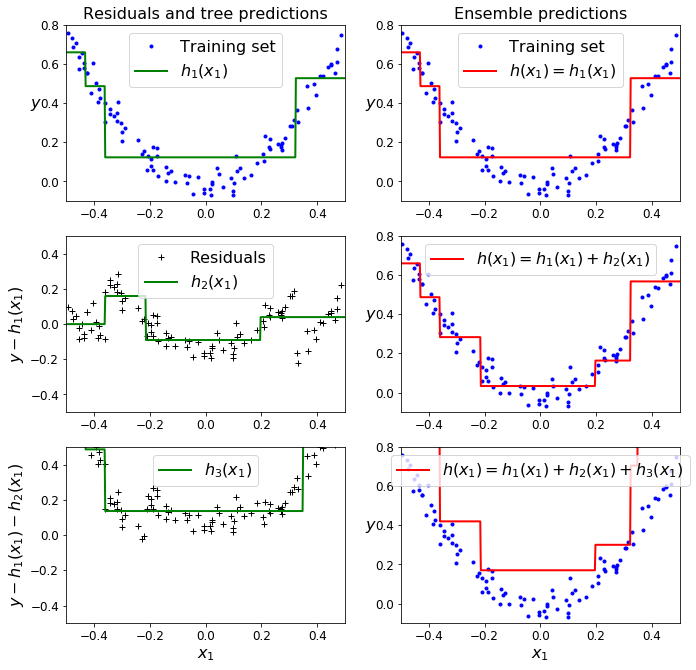

In [38]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)


plt.show()

In [39]:
#we can train GBRT using sklearn's GradientBoostingRegressor class
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called shrinkage.

In [40]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

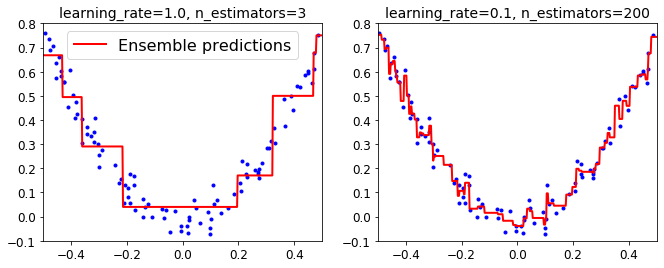

In [41]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)


plt.show()

## GBRT with Early Stopping

To find the optimal number of trees, you can use early stopping. A way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training.

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=55,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
min_error = np.min(errors)

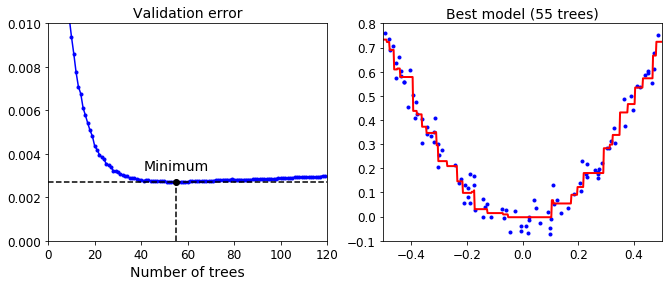

In [45]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)


plt.show()

Can also implment early stopping by actually stopping training early. You can do so by setting warm_start=True, whcih makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training.

In [46]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [47]:
print(gbrt.n_estimators)

61


## Stacking

It is based on a simple idea: instead of using trivial functions to aggregate the predictions of all predictors in an ensemble, train another model to perform aggregation.

<img src="images/chapter7/stacking.png">

Each of the bottom three predictors predicts a different value, and then the final predictor (*blender*) takes these predictions as inputs and makes the final prediction.

To train a blender, we can use an approach called "hold-out set". First, the training set is split in two subsets. The first subset is used to train predictors in the first layer.

<img src="images/chapter7/firstlayer.png">

Next, the first layer predictors are used to make predictions on the second (held-out) set.

<img src="images/chapter7/training.png">

This ensures that the predictions are clean, since the predictors never saw these instances during training. Now for each instance in the hold-out set, there are three predicted values. We can create a new training set using these predicted values as input features (which makes the new training set three-dimensional), and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value given the first layer's predictions.

It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially, as shown in the figure below:

<img src="images/chapter7/blenders.png">